# Trace Mouse Movements

### 需安裝

```
pip install pyusb

```

### Windows DLL
[libusb-win32-devel-filter-1.2.6.0.exe](https://sourceforge.net/projects/libusb-win32/files/libusb-win32-releases/1.2.6.0/)  

https://sourceforge.net/projects/libusb-win32/  



### Linux 權限
https://ubuntuforums.org/showthread.php?t=1682084  
https://linuxconfig.org/tutorial-on-how-to-write-basic-udev-rules-in-linux  
```
If anyone is interested.. fixed with udev rule:

cd /etc/udev/rules.d/

nano 70-ch341.rules

SUBSYSTEM=="usb", ATTRS{idVendor}=="1a86", GROUP="dialout"
SUBSYSTEM=="usb", ATTRS{idVendor}=="1a86", MODE="666"

then reloaded udev rules:

$ sudo udevadm control --reload-rules  
$ sudo udevadm trigger

```

In [6]:
import os, sys

def gen_relative_path(target_path): 
    
    def del_same_parents(target_path, current_path):
        if target_path[0] == current_path[0]:
            target_path.pop(0)
            current_path.pop(0)
            del_same_parents(target_path, current_path)
            
    current_path = os.getcwd().replace('\\', '/').split('/')
    target_path = target_path.replace('\\', '/').split('/')
    del_same_parents(target_path, current_path)
    
    return ['..'] * len(current_path) + target_path


def append_source_relative_path(source_relative_path):
    sys.path.append(os.sep.join(source_relative_path))

In [7]:
# paths = [gen_relative_path(p) for p in paths]
# print(paths)

In [8]:
paths = [['..', '..', '..', '..', 'Universal Serial Bus', 'bitbucket', 'github', 'codes'], 
         ['..', '..', '..', '..', '..', 'ORM', 'bitbucket', 'github', 'codes'],
         ['..', 'codes']]

for path in paths:
    append_source_relative_path(path)

In [9]:
%pylab inline  

from universal_serial_bus import * 
from usb_hid.orm.hid111 import HIDdevice 

Populating the interactive namespace from numpy and matplotlib


C:\Softwares\Python\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['array']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Choose devices

In [23]:
_, devices = find_all_devices_by_class(DEVICE_CLASS.Human_Interface_Device)
devices

[(1118, 1915), (1133, 50475)]

In [25]:
# vendor_id, product_id = 0x4d9, 0x2011  # Filco KB
# vendor_id, product_id = 0x1b3f, 0x2008 # Sound Card  
# vendor_id, product_id = 0x2341, 0x8036 # Arduino Leonardo 
vendor_id, product_id = 1118, 1915     # MS mouse  
 
dev = HIDdevice(vendor_id, product_id)

In [16]:
dev.device_descriptor

array('B', [18, 1, 0, 2, 0, 0, 0, 8, 94, 4, 123, 7, 68, 0, 1, 2, 0, 1])

In [19]:
dev.descriptors_byte_array[18:]

array('B', [9, 2, 34, 0, 1, 1, 0, 160, 50, 9, 4, 0, 0, 1, 3, 1, 2, 0, 9, 33, 17, 1, 0, 1, 34, 108, 1, 7, 5, 131, 3, 8, 0, 10])

In [20]:
dev.descriptors_from_config

[array('B', [9, 2, 34, 0, 1, 1, 0, 160, 50]),
 array('B', [9, 4, 0, 0, 1, 3, 1, 2, 0]),
 array('B', [9, 33, 17, 1, 0, 1, 34, 108, 1]),
 array('B', [7, 5, 131, 3, 8, 0, 10])]

In [21]:
# dev.descriptors

In [11]:
dev.descriptors_dbos_enum

[(0, 'StandardDeviceDescriptor'),
 (1, 'StandardConfigurationDescriptor'),
 (2, 'StandardInterfaceDescriptor'),
 (3, 'HidDescriptor'),
 (4, 'StandardEndpointDescriptor')]

In [12]:
dev.print_descriptors_dbos()

StandardDeviceDescriptor
	bLength: 0x12
	bDescriptorType: 0x01
	bcdUSB: 0x0002
	bDeviceClass: 0x00
	bDeviceSubClass: 0x00
	bDeviceProtocol: 0x00
	bMaxPacketSize0: 0x08
	idVendor: 0x5e04
	idProduct: 0x7b07
	bcdDevice: 0x4400
	iManufacturer: 0x01
	iProduct: 0x02
	iSerialNumber: 0x00
	bNumConfigurations: 0x01
StandardConfigurationDescriptor
	bLength: 0x09
	bDescriptorType: 0x02
	wTotalLength: 0x2200
	bNumInterfaces: 0x01
	bConfigurationValue: 0x01
	iConfiguration: 0x00
	bmAttributes: 0xa0
	bMaxPower: 0x32
StandardInterfaceDescriptor
	bLength: 0x09
	bDescriptorType: 0x04
	bInterfaceNumber: 0x00
	bAlternateSetting: 0x00
	bNumEndpoints: 0x01
	bInterfaceClass: 0x03
	bInterfaceSubClass: 0x01
	bInterfaceProtocol: 0x02
	iInterface: 0x00
HidDescriptor
	bLength: 0x09
	bDescriptorType: 0x21
	bcdHID: 0x1101
	bCountryCode: 0x00
	bNumDescriptors: 0x01
	bReportDescriptorType: 0x22
	wReportDescriptorLength: 0x6c01
StandardEndpointDescriptor
	bLength: 0x07
	bDescriptorType: 0x05
	bEndpointAddress: 0x83
	

In [19]:
dev.report_descriptors[0]

array('B', [5, 12, 9, 1, 161, 1, 5, 1, 9, 2, 161, 2, 133, 19, 5, 12, 10, 56, 2, 149, 1, 117, 8, 21, 129, 37, 127, 129, 6, 192, 133, 32, 6, 0, 255, 21, 0, 38, 255, 0, 117, 8, 149, 18, 10, 10, 250, 177, 2, 133, 46, 6, 0, 255, 21, 0, 38, 255, 0, 117, 8, 149, 7, 10, 10, 250, 177, 2, 133, 47, 6, 0, 255, 21, 0, 38, 255, 0, 117, 8, 149, 7, 10, 10, 250, 129, 2, 133, 24, 6, 0, 255, 21, 0, 38, 255, 0, 117, 8, 149, 1, 10, 10, 250, 177, 2, 133, 22, 5, 12, 25, 0, 42, 255, 3, 149, 1, 117, 16, 21, 0, 38, 255, 3, 129, 0, 6, 0, 255, 26, 1, 253, 42, 255, 253, 21, 1, 38, 255, 0, 117, 8, 129, 0, 129, 1, 133, 23, 10, 6, 255, 21, 0, 37, 1, 53, 1, 69, 1, 149, 1, 117, 2, 177, 2, 10, 15, 255, 69, 16, 149, 1, 117, 2, 177, 2, 10, 4, 255, 53, 0, 69, 0, 149, 1, 117, 1, 177, 2, 117, 3, 177, 1, 133, 28, 6, 0, 255, 10, 37, 255, 21, 0, 37, 4, 117, 8, 149, 1, 129, 2, 10, 38, 255, 117, 16, 21, 0, 39, 255, 255, 129, 2, 192, 5, 1, 9, 2, 161, 1, 5, 1, 9, 2, 161, 2, 133, 16, 9, 1, 161, 0, 5, 9, 25, 1, 41, 5, 149, 5, 117, 1,

In [20]:
len(dev.report_descriptors[0])

364

In [10]:
print(dev.report_descriptor_dbos[0].parse())


###################################################
array('B', [5, 12, 9, 1, 161, 1, 5, 1, 9, 2, 161, 2, 133, 19, 5, 12, 10, 56, 2, 149, 1, 117, 8, 21, 129, 37, 127, 129, 6, 192, 133, 32, 6, 0, 255, 21, 0, 38, 255, 0, 117, 8, 149, 18, 10, 10, 250, 177, 2, 133, 46, 6, 0, 255, 21, 0, 38, 255, 0, 117, 8, 149, 7, 10, 10, 250, 177, 2, 133, 47, 6, 0, 255, 21, 0, 38, 255, 0, 117, 8, 149, 7, 10, 10, 250, 129, 2, 133, 24, 6, 0, 255, 21, 0, 38, 255, 0, 117, 8, 149, 1, 10, 10, 250, 177, 2, 133, 22, 5, 12, 25, 0, 42, 255, 3, 149, 1, 117, 16, 21, 0, 38, 255, 3, 129, 0, 6, 0, 255, 26, 1, 253, 42, 255, 253, 21, 1, 38, 255, 0, 117, 8, 129, 0, 129, 1, 133, 23, 10, 6, 255, 21, 0, 37, 1, 53, 1, 69, 1, 149, 1, 117, 2, 177, 2, 10, 15, 255, 69, 16, 149, 1, 117, 2, 177, 2, 10, 4, 255, 53, 0, 69, 0, 149, 1, 117, 1, 177, 2, 117, 3, 177, 1, 133, 28, 6, 0, 255, 10, 37, 255, 21, 0, 37, 4, 117, 8, 149, 1, 129, 2, 10, 38, 255, 117, 16, 21, 0, 39, 255, 255, 129, 2, 192, 5, 1, 9, 2, 161, 1, 5, 1, 9, 2, 161, 2, 133, 

## Get Reports

In [11]:
dev.endpoints

{131: <ENDPOINT 0x83: Interrupt IN>}

In [12]:
collected = 0
attempts = 20

ep = dev.endpoints[131]

while collected < attempts :
    try:
        data = ep.read(8)
        collected += 1
        print (data)
        
    except usb.core.USBError as e:
        print(e)

usb.util.release_interface(dev, 0)

array('B', [16, 0, 6, 0, 255, 255, 0, 0])
array('B', [16, 0, 176, 2, 105, 3, 0, 0])
array('B', [16, 0, 1, 0, 91, 0, 0, 0])
array('B', [16, 0, 0, 0, 88, 0, 0, 0])
array('B', [16, 0, 0, 0, 86, 0, 0, 0])
array('B', [16, 0, 255, 255, 81, 0, 0, 0])
array('B', [16, 0, 255, 255, 77, 0, 0, 0])
array('B', [16, 0, 0, 0, 71, 0, 0, 0])
array('B', [16, 0, 254, 255, 63, 0, 0, 0])
array('B', [16, 0, 254, 255, 61, 0, 0, 0])
array('B', [16, 0, 255, 255, 53, 0, 0, 0])
array('B', [16, 0, 255, 255, 45, 0, 0, 0])
array('B', [16, 0, 255, 255, 38, 0, 0, 0])
array('B', [16, 0, 255, 255, 32, 0, 0, 0])
array('B', [16, 0, 254, 255, 25, 0, 0, 0])
array('B', [16, 0, 0, 0, 17, 0, 0, 0])
array('B', [16, 0, 0, 0, 11, 0, 0, 0])
array('B', [16, 0, 0, 0, 3, 0, 0, 0])
array('B', [16, 0, 0, 0, 1, 0, 0, 0])
array('B', [16, 0, 1, 0, 252, 255, 0, 0])


In [13]:
from time import time 

def get_mouse_offset(endpoint, length = 8):    
    try:
        data = ep.read(8)
        t = time()
        x, y = (OrmClassBase.byte_array_to_int(data[i:i+2], byteorder = 'little', signed = True) for i in (2, 4))
        return (data, t, x, y)
    
    except usb.core.USBError as e:
        return None
    

def trace_mouse(endpoint, attempts = 500, length = 8):    
    collected = 0
    traces = []

    while collected < attempts :
        result = get_mouse_offset(ep, length = 8)
        
        if result is not None:
            data, t, x, y = result
            traces.append((t, x, y))
            collected += 1

    usb.util.release_interface(ep.device, 0)
    
    return traces

In [14]:
ep = dev.endpoints[131]

traces = trace_mouse(ep, attempts = 500)
traces[:5]

[(1575276864.9933596, 1, -11),
 (1575276865.0013595, 2, -22),
 (1575276865.0097272, 6, -107),
 (1575276865.0168347, 1, -48),
 (1575276865.0256906, 2, -53)]

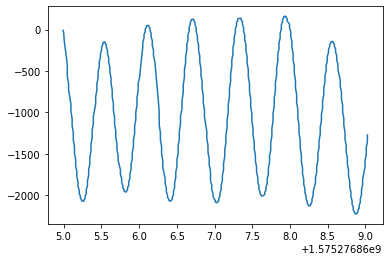

In [16]:
traces = np.array(traces)

t = traces[:, 0]
y = traces[:, 2]
y = np.cumsum(y)

plt.plot(t, y);